In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import LayerNormalization

In [2]:
class BaselineRegressor:
    """
    Baseline regressor, which calculates the mean value of the target from the training
    data and returns it for each testing sample.
    """
    def __init__(self):
        self.mean = 0

    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
        self.mean = np.mean(y_train, axis=0)
        self.classes_count = y_train.shape[1]
        return self

    def predict(self, X_test: np.ndarray):
        return np.full((len(X_test), self.classes_count), self.mean)

class SpectralCurveFiltering():
    """
    Create a histogram (a spectral curve) of a 3D cube, using the merge_function
    to aggregate all pixels within one band. The return array will have
    the shape of [CHANNELS_COUNT]
    """

    def __init__(self, merge_function = np.mean):
        self.merge_function = merge_function

    def __call__(self, sample: np.ndarray):
        return self.merge_function(sample, axis=(1, 2))

In [3]:
import os
from glob import glob

def load_data(directory: str):
    """Load each cube, reduce its dimensionality and append to array.

    Args:
        directory (str): Directory to either train or test set
    Returns:
        [type]: A list with spectral curve for each sample.
    """
    data = []
    #filtering = SpectralCurveFiltering()
    all_files = np.array(
        sorted(
            glob(os.path.join(directory, "*.npz")),
            key=lambda x: int(os.path.basename(x).replace(".npz", "")),
        )
    )
    c = 0
    for file_name in all_files:
        if c == 649:
            break
        else:
            print(c,end="")
            with np.load(file_name) as npz:
                arr = np.ma.MaskedArray(**npz)
            # arr shape is (150,x,y)
            t = []
            for i in range(11):
                l = []
                for j in range(11):
                    l.append(arr[:,i,j])
                t.append(l)
            # shape of t is (x,y,150)
            c = c + 1
            data.append(t)
    return tf.convert_to_tensor(data)
def load_gt(file_path: str):
    """Load labels for train set from the ground truth file.
    Args:
        file_path (str): Path to the ground truth .csv file.
    Returns:
        [type]: 2D numpy array with soil properties levels
    """
    gt_file = pd.read_csv(file_path)
    labels = gt_file[["P", "K", "Mg", "pH"]].values
    return labels

In [4]:
# X_train is tf tensor
# y_train is a pandas df
X_train = load_data("train_data")
y_train = load_gt("train_gt.csv")
#X_test = load_data("test_data")

0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100101102103104105106107108109110111112113114115116117118119120121122123124125126127128129130131132133134135136137138139140141142143144145146147148149150151152153154155156157158159160161162163164165166167168169170171172173174175176177178179180181182183184185186187188189190191192193194195196197198199200201202203204205206207208209210211212213214215216217218219220221222223224225226227228229230231232233234235236237238239240241242243244245246247248249250251252253254255256257258259260261262263264265266267268269270271272273274275276277278279280281282283284285286287288289290291292293294295296297298299300301302303304305306307308309310311312313314315316317318319320321322323324325326327328329330331332333334335336337338339340341342343344345346347348349350351352353354355356357358359360361362363364365366367368369

In [5]:
print(f"Features of Train data shape: {X_train.shape}")
#print(f"Features of Test data shape: {X_test.shape}")
print(f"Labesl of Training data shape: {y_train.shape}")

Features of Train data shape: (649, 11, 11, 150)
Labesl of Training data shape: (1732, 4)


In [6]:
Y_train = y_train[:649]

In [7]:
Y_train = tf.convert_to_tensor(Y_train)
Y_train.shape

TensorShape([649, 4])

In [8]:
X_train_norm = tf.keras.utils.normalize(X_train, axis=-1)
Y_train_norm = tf.keras.utils.normalize(Y_train, axis=-1)

In [9]:
x_train = X_train_norm[:510]
x_test = X_train_norm[510:]
y_train = Y_train[:510]
y_test = Y_train[510:]

In [10]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(510, 11, 11, 150)
(139, 11, 11, 150)
(510, 4)
(139, 4)


In [337]:
def scale_datasets(d):
    """
      Standard Scale test and train data
      Z - Score normalization
      """
    standard_scaler = StandardScaler()
    d_scaled = pd.DataFrame(standard_scaler.fit_transform(d),
          columns=d.columns)

    return d_scaled

In [338]:
#X_train_df = pd.DataFrame(X_train)
#X_test_df = pd.DataFrame(X_test)
y_train_df = pd.DataFrame(y_train)
#x_train_scaled = scale_datasets(X_train_df)

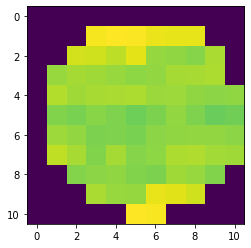

In [339]:
plt.imshow(X_train_norm[10,:,:,11])

In [340]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

from keras import backend as K

In [341]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [365]:
input_shape = (11,11,150)

model = Sequential()
#model.add(Dense(256, activation='relu', input_dim=366))
model.add(Conv2D(256, (1, 1), activation='relu', input_shape = input_shape))
model.add(BatchNormalization())
model.add(Conv2D(256, (1, 1), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (1, 1), activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(16, (3, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (3, 3), activation = 'relu'))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(4, activation='linear'))


model.compile(loss='mean_squared_error', # one may use 'mean_absolute_error' as  mean_squared_error
                  optimizer='adam',
                  metrics=[r2_keras] # you can add several if needed
                 )
model.summary()

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_119 (Conv2D)          (None, 11, 11, 256)       38656     
_________________________________________________________________
batch_normalization_55 (Batc (None, 11, 11, 256)       1024      
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 11, 11, 256)       65792     
_________________________________________________________________
batch_normalization_56 (Batc (None, 11, 11, 256)       1024      
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 11, 11, 128)       32896     
_________________________________________________________________
batch_normalization_57 (Batc (None, 11, 11, 128)       512       
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 9, 9, 32)        

In [366]:
# loss function
mse = MeanSquaredError()
model.compile(
    loss= mse , # one may use 'mean_absolute_error' as  mean_squared_error
    optimizer= 'adam',
    metrics=[r2_keras] # you can add several if needed
)

In [368]:
# train the model
history = model.fit(
    x_train, 
    y_train, 
    epochs = 20, 
    batch_size = 5,
    validation_data = (x_test,y_test)
)

Epoch 1/20
102/102 [==============================] - 2s 21ms/step - loss: 1811.3890 - r2_keras: 0.8002 - val_loss: 1430.7561 - val_r2_keras: 0.8328
Epoch 2/20
102/102 [==============================] - 2s 23ms/step - loss: 1824.7056 - r2_keras: 0.8008 - val_loss: 1472.0312 - val_r2_keras: 0.8343
Epoch 3/20
102/102 [==============================] - 3s 26ms/step - loss: 1795.9053 - r2_keras: 0.8028 - val_loss: 1492.8951 - val_r2_keras: 0.8319
Epoch 4/20
102/102 [==============================] - 3s 25ms/step - loss: 1808.1273 - r2_keras: 0.8044 - val_loss: 1420.1031 - val_r2_keras: 0.8383
Epoch 5/20
102/102 [==============================] - 3s 25ms/step - loss: 1788.5870 - r2_keras: 0.8017 - val_loss: 1394.7806 - val_r2_keras: 0.8380
Epoch 6/20
102/102 [==============================] - 3s 27ms/step - loss: 1793.3367 - r2_keras: 0.8033 - val_loss: 1374.5626 - val_r2_keras: 0.8389
Epoch 7/20
102/102 [==============================] - 3s 25ms/step - loss: 1802.8469 - r2_keras: 0.7992 - 

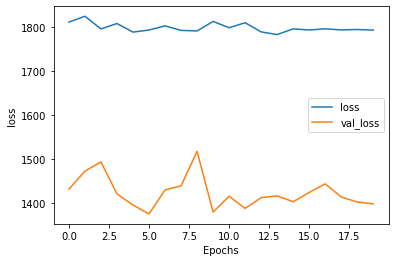

In [369]:
def plot_history(history, key):
    plt.plot(history.history[key])
    plt.plot(history.history['val_'+key])
    plt.xlabel("Epochs")
    plt.ylabel(key)
    plt.legend([key, 'val_'+key])
    plt.show()
# Plot the history
plot_history(history, 'loss')

In [370]:
predictions = model.predict(x_test)

In [375]:
for i in range(len(predictions)):
    print(predictions[i],end=" ")
    print(y_test[i])
    #print(predictions[i] - y_test[i])

[ 69.244774 214.13129  163.55612    6.957708] tf.Tensor([ 59.7 222.  142.    6.6], shape=(4,), dtype=float64)
[ 75.65153   222.01741   163.25336     7.0375857] tf.Tensor([ 47.3 197.  145.    6.9], shape=(4,), dtype=float64)
[ 75.53683   221.41843   161.87225     7.0348616] tf.Tensor([ 68.2 191.  131.    6.9], shape=(4,), dtype=float64)
[ 67.47662   209.55081   160.58514     6.9227586] tf.Tensor([ 46.9 240.  182.    7. ], shape=(4,), dtype=float64)
[ 75.38503  221.21338  162.26292    6.998371] tf.Tensor([ 73.  252.  226.    6.8], shape=(4,), dtype=float64)
[ 75.66076   222.02827   163.25111     7.0397854] tf.Tensor([ 82.9 228.  203.    6.8], shape=(4,), dtype=float64)
[ 70.61639  212.17845  157.64099    6.988228] tf.Tensor([158.  214.  181.    6.6], shape=(4,), dtype=float64)
[ 70.141716  210.4112    154.27972     6.9836426] tf.Tensor([136.  269.  219.    6.7], shape=(4,), dtype=float64)
[ 70.59446  216.86876  164.8901     6.991705] tf.Tensor([116.  338.  236.    6.7], shape=(4,), dtype

In [372]:




# Generate baseline values to be used in score computation
baselines = [5.49588849e+02, 3.75637553e+03, 6.44225516e+02, 5.66444647e-02]
"""
# Generate random predictions, different from baseline predictions
np.random.seed(0)
predictions = np.zeros_like(y_test)
for column_index in range(predictions.shape[1]):
    class_mean_value = baseline_reg.mean[column_index]
    predictions[:, column_index] = np.random.uniform(low=class_mean_value - class_mean_value * 0.05,
                                                     high=class_mean_value + class_mean_value * 0.05,
                                                     size=len(predictions))
                                                     
"""



predictions = model.predict(x_test)
predictions = np.array(predictions)
# Calculate MSE for each class
mse = np.mean((y_test - predictions) ** 2, axis=0)

# Calculate the score for each class individually
scores = mse / baselines

# Calculate the final score
final_score = np.mean(scores)

for score, class_name in zip(scores, ["P", "K", "Mg", "pH"]):
    print(f"Class {class_name} score: {score}")

print(f"Final score: {final_score}")

Class P score: 1.548277958526374
Class K score: 0.5547777658008622
Class Mg score: 4.12072141750536
Class pH score: 1.6557580714314408
Final score: 1.969883803316009


model.save('model_10_4_0.909554.h5')

In [42]:
predictions

array([[ 72.93418  , 234.85641  , 161.67876  ,   6.8167214],
       [ 70.77814  , 260.52066  , 158.71931  ,   6.620297 ],
       [ 71.64629  , 259.25842  , 159.78922  ,   6.6660504],
       [ 71.0745   , 259.9715   , 159.3257   ,   6.6399093],
       [ 72.214836 , 257.80057  , 160.70352  ,   6.7040744],
       [ 73.26794  , 230.08315  , 160.30165  ,   6.8444123],
       [ 70.32172  , 260.92108  , 158.3262   ,   6.5998087],
       [ 70.08148  , 261.1133   , 158.10483  ,   6.588436 ],
       [ 70.44481  , 260.58398  , 158.88994  ,   6.608723 ],
       [ 74.54772  , 226.66748  , 158.41194  ,   6.8955827],
       [ 70.88518  , 234.03798  , 161.72311  ,   6.706974 ],
       [ 69.9412   , 261.15     , 158.14746  ,   6.5835786],
       [ 73.58524  , 228.81566  , 159.30798  ,   6.8711867],
       [ 72.79689  , 230.45027  , 160.00569  ,   6.8408604],
       [ 72.584465 , 231.14613  , 160.38766  ,   6.827169 ],
       [ 71.90238  , 258.31168  , 160.53159  ,   6.6821976],
       [ 73.89835  , 236

In [43]:
y_test

array([[ 49.9, 175. , 178. ,   6.8],
       [ 35. , 147. , 146. ,   6.4],
       [ 28.3, 147. , 144. ,   6.4],
       [ 31.1, 157. , 177. ,   6.6],
       [ 35.3, 157. , 190. ,   6.6],
       [ 44.7, 172. , 176. ,   6.6],
       [ 36.8, 163. , 173. ,   6.4],
       [ 39.8, 162. , 181. ,   6.4],
       [ 33.1, 164. , 182. ,   6.3],
       [ 36.9, 147. , 175. ,   6.4],
       [ 41.1, 180. , 180. ,   6.6],
       [ 44.2, 174. , 188. ,   6.7],
       [ 54.4, 181. , 198. ,   6.5],
       [ 55.4, 168. , 187. ,   6.7],
       [ 47.8, 167. , 191. ,   6.7],
       [ 29.5, 164. , 212. ,   6.7],
       [ 29.9, 149. , 202. ,   6.6],
       [ 62.5, 193. , 167. ,   6.8],
       [ 51. , 175. , 150. ,   6.8],
       [ 42. , 168. , 152. ,   6.9],
       [ 39.1, 178. , 140. ,   6.6],
       [ 44.2, 202. , 134. ,   6.8],
       [ 40.3, 166. , 150. ,   6.5],
       [ 38.9, 189. , 169. ,   6.5],
       [ 39.4, 171. , 159. ,   6.6],
       [ 49.8, 162. , 145. ,   6.5],
       [ 47.9, 170. , 146. ,   6.5],
 

In [44]:
baseline_predictions

array([[ 70.79933333, 234.18273333, 160.7572    ,   6.79858   ],
       [ 70.79933333, 234.18273333, 160.7572    ,   6.79858   ],
       [ 70.79933333, 234.18273333, 160.7572    ,   6.79858   ],
       [ 70.79933333, 234.18273333, 160.7572    ,   6.79858   ],
       [ 70.79933333, 234.18273333, 160.7572    ,   6.79858   ],
       [ 70.79933333, 234.18273333, 160.7572    ,   6.79858   ],
       [ 70.79933333, 234.18273333, 160.7572    ,   6.79858   ],
       [ 70.79933333, 234.18273333, 160.7572    ,   6.79858   ],
       [ 70.79933333, 234.18273333, 160.7572    ,   6.79858   ],
       [ 70.79933333, 234.18273333, 160.7572    ,   6.79858   ],
       [ 70.79933333, 234.18273333, 160.7572    ,   6.79858   ],
       [ 70.79933333, 234.18273333, 160.7572    ,   6.79858   ],
       [ 70.79933333, 234.18273333, 160.7572    ,   6.79858   ],
       [ 70.79933333, 234.18273333, 160.7572    ,   6.79858   ],
       [ 70.79933333, 234.18273333, 160.7572    ,   6.79858   ],
       [ 70.79933333, 234

In [57]:
X_test_scaled

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,0.726193,0.718788,0.711902,0.710853,0.700255,0.692241,0.681627,0.668595,0.656536,0.647982,...,1.272030,1.276808,1.281743,1.286859,1.291849,1.296756,1.301475,1.306240,1.310712,1.315082
1,1.290381,1.296579,1.301976,1.291500,1.296652,1.289527,1.288339,1.283524,1.272430,1.270922,...,1.843312,1.844614,1.846459,1.848363,1.850101,1.851665,1.852926,1.854204,1.855521,1.856609
2,1.219846,1.223259,1.224252,1.221743,1.218602,1.213731,1.209352,1.203094,1.194693,1.189517,...,1.636782,1.640010,1.644387,1.648911,1.653304,1.657571,1.661614,1.665669,1.669627,1.673464
3,1.436092,1.427356,1.416976,1.420120,1.410095,1.408772,1.402553,1.396352,1.392070,1.385362,...,1.699533,1.690972,1.683252,1.674935,1.666468,1.657836,1.648988,1.640084,1.631139,1.622080
4,1.458031,1.453883,1.448549,1.436739,1.437275,1.434271,1.427692,1.424748,1.422082,1.408911,...,1.995158,1.989646,1.983286,1.976466,1.969440,1.962084,1.954469,1.946868,1.939159,1.931241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,0.882608,0.877422,0.869609,0.871475,0.865838,0.864819,0.862438,0.859535,0.860270,0.863890,...,0.616115,0.617835,0.619447,0.621094,0.622825,0.624605,0.626426,0.628163,0.629884,0.631713
228,2.006218,2.015184,2.022365,2.013470,2.021771,2.016598,2.016055,2.009685,1.995624,1.991447,...,1.827390,1.832308,1.836722,1.841393,1.846009,1.850407,1.854586,1.858829,1.863321,1.867618
229,1.001177,1.010127,1.018665,1.012769,1.025046,1.024264,1.030953,1.033093,1.029449,1.035806,...,0.889302,0.889768,0.890748,0.891812,0.892938,0.894006,0.895052,0.896058,0.897150,0.898236
230,0.655089,0.660126,0.667572,0.670882,0.676875,0.680208,0.685286,0.688920,0.692191,0.698626,...,0.605308,0.608564,0.612175,0.615945,0.619819,0.623727,0.627716,0.631605,0.635439,0.639384


In [58]:
x_train_scaled

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,0.652078,0.663276,0.675623,0.671132,0.684131,0.691882,0.698090,0.708701,0.715701,0.726942,...,-0.376381,-0.376003,-0.374861,-0.373525,-0.372196,-0.370658,-0.369109,-0.367449,-0.365606,-0.363653
1,1.625802,1.613999,1.608296,1.601378,1.582855,1.576423,1.557913,1.537080,1.505372,1.483189,...,0.866953,0.868881,0.871085,0.873424,0.875922,0.878702,0.882175,0.886256,0.890744,0.895692
2,0.393017,0.369263,0.373474,0.381552,0.386026,0.387586,0.383366,0.383163,0.376369,0.365708,...,-0.737755,-0.739786,-0.742370,-0.745117,-0.747817,-0.750669,-0.753553,-0.756490,-0.759606,-0.762825
3,2.152007,2.163870,2.168227,2.173823,2.182118,2.194740,2.205199,2.229988,2.255784,2.280437,...,-0.099829,-0.097904,-0.096225,-0.094393,-0.092417,-0.090374,-0.087832,-0.085245,-0.082041,-0.078840
4,0.217972,0.204382,0.197730,0.196857,0.189605,0.196646,0.204839,0.213986,0.220745,0.230878,...,-0.440709,-0.442779,-0.444559,-0.446523,-0.448526,-0.450481,-0.452226,-0.454127,-0.455875,-0.457537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1727,-0.067468,-0.062301,-0.059193,-0.048906,-0.041547,-0.030373,-0.018229,-0.004925,0.012279,0.030780,...,-0.563291,-0.562910,-0.562456,-0.561981,-0.561466,-0.560929,-0.560347,-0.559784,-0.559161,-0.558477
1728,0.698111,0.716109,0.733806,0.741263,0.764151,0.777527,0.797234,0.815276,0.829898,0.850488,...,-0.251318,-0.249910,-0.248167,-0.246263,-0.244301,-0.242214,-0.239861,-0.237424,-0.234675,-0.231745
1729,0.013320,0.028490,0.043345,0.048858,0.069423,0.081468,0.100890,0.118844,0.134112,0.155759,...,-0.492930,-0.492826,-0.492409,-0.491940,-0.491427,-0.490883,-0.490250,-0.489612,-0.488850,-0.488017
1730,-0.222489,-0.210966,-0.198177,-0.187700,-0.173256,-0.159866,-0.143454,-0.126595,-0.108763,-0.089363,...,-0.566074,-0.565299,-0.564334,-0.563313,-0.562245,-0.561157,-0.560011,-0.558883,-0.557699,-0.556449
